In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

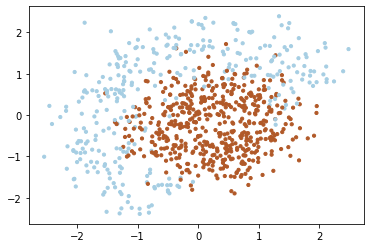

In [0]:
with open('train.npy', 'rb') as fin:
    X = np.load(fin)
    
with open('labels.npy', 'rb') as fin:
    y = np.load(fin)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=10)
plt.show()

## Add Features
*   The data above isn't linearly separable that why I will add some features. I can add quadratic features to make the problem linearly separable. We will move from 2D to 3D representation.


In [0]:
def add_features(X):
    """
    Adding quadratic features. 
    
    We will add these features to our matrix X
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: matrix of features, shape [n_samples,2]
    :returns: matrix features of shape [n_samples,6]
    """
    X_new = np.zeros((X.shape[0], 6))
    X_new[:, 0] = X[:, 0]
    X_new[:, 1] = X[:, 1]
    X_new[:, 2] = X[:, 0] ** 2
    X_new[:, 3] = X[:, 1] ** 2
    X_new[:, 4] = X[:, 0] * X[:, 1] 
    X_new[:, 5] = 1
    return X_new

In [0]:
X_expanded = add_features(X)

In [0]:
print("Original features matrix shape :", X.shape)
print("New features matrix shape :", X_expanded.shape)

Original features matrix shape : (826, 2)
New features matrix shape : (826, 6)


## Logistic Regression
*   We will map the logits from the output of the linear model <W, x> to probability distrubtion.
*   If a sample belongs to class 1, its probabality will be given by :
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$




In [0]:
def calculate_probability(X, w):
    """
    Given input features and weights
    return predicted probabilities of y==1 given x, P(y=1|x)
    """

    """
    :param X: feature matrix X of shape [n_samples,6]
    :param w: weight vector w of shape [6] for each of the expanded features
    :returns: an array of predicted probabilities in [0,1] interval.
    """

    # TODO:<your code here>
    X_new=add_features(X)
    return 1 / (1 + np.exp(-np.dot(X_new, w)))

In [0]:
weights = np.linspace(-1, 1, 6)
predicted_probablilites = calculate_probability(X, weights)[0:10]

In [0]:
print(predicted_probablilites)

[0.38039985 0.53100076 0.57466019 0.7816769  0.40812873 0.65685624
 0.63380988 0.71703014 0.42939941 0.67283177]




*   We will use cross-entropy function as our loss function
$$ l(x_i, y_i, w) = - \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1\, | \, x_i,w))}\right] $$
*  To calculate the data loss, we will average across all the samples 
$$ L(X, y, w) =  {1 \over \ell} \sum_{i=1}^\ell l(x_i, y_i, w) $$





In [0]:
def compute_loss(X, y, w):
    """
    Given :
          Feature matrix X [n_samples,6], 
          Target vector [n_samples] of 1s and 0s,
          Weight vector w [6], 
    Output:
          Scalar loss function L.
    """

    p = calculate_probability(X, w)
    return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

In [0]:
loss= compute_loss(add_features(X), y, weights)
print(loss)

1.0185634030782518


## Gradient

Now we will minimize our loss function using Gradient Descent. To do that, we need to compute the gradients

$$ \nabla_w L = {1 \over \ell} \sum_{i=1}^\ell \nabla_w l(x_i, y_i, w) $$ 

In [0]:
def compute_grad(X, y, w):
    """
    Given : 
          Feature matrix X [n_samples,6]
          Label vector [n_samples] of 1s and 0s
          Weight vector w [6], 
    Output : 
          Vector [6] of derivatives of L over each weights.
    """
    
    return np.dot(X.T, calculate_probability(X, w) - y) / X.shape[0]

In [0]:
gradients= compute_grad(add_features(X), y, weights)
print(gradients.shape)
print(gradients)

(6,)
[-0.32741296  0.05429288  0.31961242  0.38946883  0.2029897   0.06801579]


In [0]:
from IPython import display

In [0]:
h = 0.01
x_min, x_max = X[:, 0].min() - 2, X[:, 0].max() + 2
y_min, y_max = X[:, 1].min() - 2, X[:, 1].max() + 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [0]:
def visualize(X, y, w, history):
    """
    draws classifier prediction with matplotlib magic
    """
    
    Z = calculate_probability(add_features(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.9)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

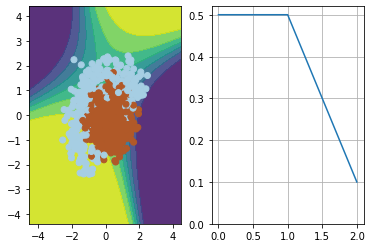

In [0]:
visualize(X, y, weights, [0.5, 0.5, 0.1])

## Training
*   Now we will train our classifier using stochastic gradient descent.
*   We can try different hyperparameters:
      *   Batch size
      *   Learning rate



### Mini-Batch Gradient Descent (MBGD)
*   It takes a random examples from data cloud, calculates the gradient for every of these examples and averages their gradients.



$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w l(x_{i_j}, y_{i_j}, w_t) $$

In [0]:
np.random.seed(42)
# Weight initialization
w = np.array([0, 0, 0, 0, 0, 1])

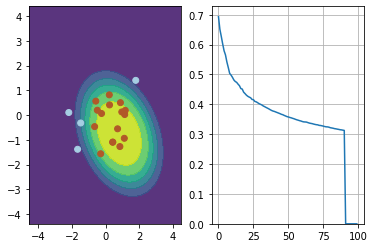

In [0]:
# HParameters
alpha= 0.1 
batch_size = 20


n_iter = 100
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)

    w = w - alpha * compute_grad(X_expanded[ind, :], y[ind], w)

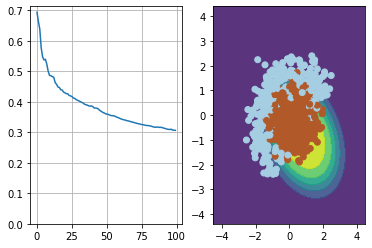

<Figure size 432x288 with 0 Axes>

In [0]:
visualize(X, y, w, loss)
plt.clf()

### Momentum
*   It helps accelerate SGD in the relevant direction and prevents oscillations. It does this by accumulating gradients from all previous steps. 



$$ g_t= \dfrac{1}{m} \sum_{j=1}^m \nabla_w l(x_{i_j}, y_{i_j}, w_t) $$

$$ h_t= \alpha h_{t-1} + \eta g_t$$

$$ w_t= w_{t-1} - h_t$$

In [0]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

In [0]:
# learning rate
eta = 0.05 
# momentum
alpha = 0.9 

batch_size = 10
h = np.zeros_like(w)

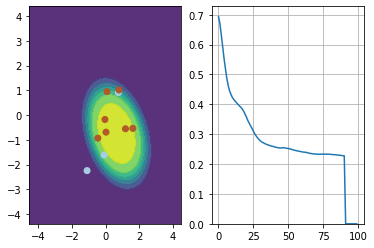

In [99]:
n_iter = 100


loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)

    
    h = alpha * h + eta * compute_grad(X_expanded[ind, :], y[ind], w)
    w = w - h    

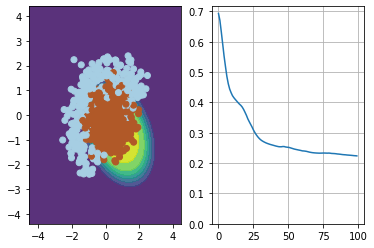

<Figure size 432x288 with 0 Axes>

In [0]:
visualize(X, y, w, loss)
plt.clf()

### RMSprop

*   It is kind of adaptive learning algorithm where we dont need to think about the learning rate and how to select it.



$$ G_j^t = \alpha G_j^{t-1} + (1 - \alpha) g_{tj}^2 $$

$$ w_j^t = w_j^{t-1} - \dfrac{\eta}{\sqrt{G_j^t + \varepsilon}} g_{tj} $$

In [0]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1.])

In [0]:
# Learning rate
eta = 0.1 
alpha = 0.9 
eps = 1e-8 # just to not divide by zero

g2 = None
G=0

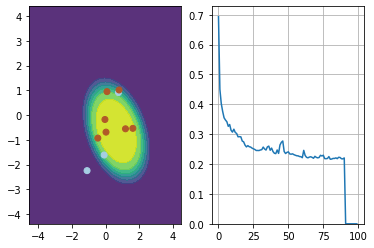

In [106]:
n_iter = 100
batch_size = 10


loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)


    g = compute_grad(X_expanded[ind, :], y[ind], w)
    g2 = g ** 2
    G = alpha * G + (1 - alpha) * g2
    w = w - eta * g / (np.sqrt(G + eps))

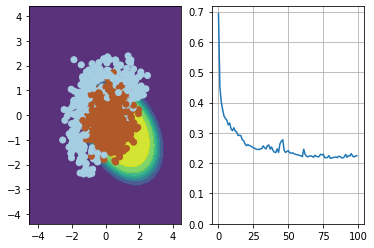

<Figure size 432x288 with 0 Axes>

In [107]:
visualize(X, y, w, loss)
plt.clf()